### 분류(Classification)와 군집화(Clustering)
- 분류
    - 주어진 데이터 집합을 이미 정의된 몇 개의 클래스로 구분하는 것
    - 문제 지도학습(Supervised Leaning) 숫자 인식, 얼굴인식 등 
    - Bayes classifier, k-Nearest Neighbor, Support Vector Machine 등
- 군집
    - 입력 데이터의 분포 특성(입력값의 유사성)을 분석하여 임의의 복수 개의 그룹으로 나누는 것 
    - 비지도학습(Unsupervised Leaning), 영상분리 K-means clustering, Leaning Vector Quantization, SOM 등

#### 표준라이브러리로딩

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### 데이터 로딩

In [2]:
train = pd.read_csv('../data/titanic_train.csv')
test = pd.read_csv('../data/titanic_test.csv')
train.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,body,home.dest
0,2,1,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.5000,NaN,S,NaN,"England / Bennington, VT"
1,2,1,"Wells, Miss. Joan",female,4.0,1,1,29103,23.0000,NaN,S,NaN,"Cornwall / Akron, OH"
2,2,1,"Duran y More, Miss. Florentina",female,30.0,1,0,SC/PARIS 2148,13.8583,NaN,C,NaN,"Barcelona, Spain / Havana, Cuba"
3,3,0,"Scanlan, Mr. James",male,NaN,0,0,36209,7.7250,NaN,Q,NaN,NaN
4,3,1,"Bradley, Miss. Bridget Delia",female,22.0,0,0,334914,7.7250,NaN,Q,NaN,"Kingwilliamstown, Co Cork, Ireland Glens Falls..."


### 데이터 셋의 피처
|피처 이름|설명|
|---|---|
pclass|Passenger Class, 승객 등급
survived|생존여부(생존 1, 사망 0)
name|승객 이름
sex|승객 성별
age|승객 나이
sibsp|동승한 형제 또는 배우자 수
parch|동승한 부모 또는 자녀 수
ticket|티켓번호
fare|승객지불요금
cabin|선실 이름
embarked|승선항(C-쉘부르크, Q-퀸즈, S-사우스햄튼)
body|사망자확인번호
home.dest|고향/목적지

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 13 columns):
pclass       916 non-null int64
survived     916 non-null int64
name         916 non-null object
sex          916 non-null object
age          741 non-null float64
sibsp        916 non-null int64
parch        916 non-null int64
ticket       916 non-null object
fare         916 non-null float64
cabin        214 non-null object
embarked     914 non-null object
body         85 non-null float64
home.dest    527 non-null object
dtypes: float64(3), int64(4), object(6)
memory usage: 93.1+ KB


In [4]:
# 불필요한 피처를 제거하는 작업
train = train.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis=1)
test = test.drop(['name', 'ticket', 'body', 'cabin', 'home.dest'], axis=1)

### 데이터 탐색과 시각화

In [ ]:
train['survived'].value_counts().plot.bar()

#### 전체 데이터의 분포를 시각화(Pie Chart)
- sex
- pclass
- embarked

In [5]:
def pie_chart(feature):
    feature_ratio = train[feature].value_counts(sort=False)
    feature_size = feature_ratio.size
    survived = train[train['survived'] == 1][feature].value_counts()
    dead = train[train['survived'] == 0][feature].value_counts()
    feature_index = feature_ratio.index
    
    plt.plot(aspect='auto')
    plt.pie(feature_ratio, labels=feature_index, autopct='%1.1f%%')
    plt.title(feature+"\'s ratio in total")
    plt.show()
    
    for i, index in enumerate(feature_index):
        plt.subplot(1, feature_size + 1, i + 1, aspect='equal')
        plt.pie([survived[index], dead[index]],
                labels=['Survived', 'Dead'], autopct='%1.1f%%')
        plt.title(str(index) + "\'s ratio" )
        
    plt.show()

In [ ]:
pie_chart('sex')

In [ ]:
pie_chart('pclass')

In [ ]:
pie_chart('embarked')

In [ ]:
# def bar_chart(feature):
#     survived = train[train['survived'] == 1][feature].value_counts()
#     dead = train[train['survived'] == 0][feature].value_counts()
#     feature_index = feature_ratio.index

#     df = pd.DataFrame([survived, dead])
#     df.index = ['Survived', 'Dead']


### 데이터 전처리 및 특성 추출

In [ ]:
train.describe()

### age, sibsp 수치형 피처 탐색
- 두 그룹 간의 분포를 시각화
- 두 그룹 각각의 표준편차
- 두 그룹간의 T-test검정(전제: 정규분포에 따라야한다)
- 정규분포 검정 : Shapiro-wilk 검정

In [6]:
from scipy import stats

# 두 집단의 작업을 자동화(유효성 검사)하는 함수 구현
def valid_features(df, col_name, distribution_check=True):
    
    # 분포의 시각화(survived=1, servived=0)
    g = sns.FacetGrid(df, col='survived')
    g.map(plt.hist, col_name, bins=30)
    
    # 표준편차
    titanic_survived = df[df['survived'] == 1]
    titanic_survived_static = np.array(titanic_survived[col_name])
    print(f'data std is {np.std(titanic_survived_static):.2f}')
    
    titanic_dead = df[df['survived'] == 0]
    titanic_dead_static = np.array(titanic_dead[col_name])
    print(f'data std is {np.std(titanic_dead_static):.2f}')
    
    # T-test: 평균차이를 검정
    tTestResult = stats.ttest_ind(titanic_survived[col_name],
                                  titanic_dead[col_name], equal_var=False)
    tTestResultDiffVar = stats.ttest_ind(titanic_survived[col_name],
                                  titanic_dead[col_name], equal_var=False)
    print('T-test 통계량 %.3f and p-value %.3f' % (tTestResult))
    print('T-test 통계량 %.3f and p-value %.3f' % (tTestResultDiffVar))
    
    if distribution_check:
        #Shapiro-wilk 검정
        print('Shapiro-wilk 통계량 %.3f and p-value %.3f' % (stats.shapiro(titanic_survived[col_name])))
        print('Shapiro-wilk 통계량 %.3f and p-value %.3f' % (stats.shapiro(titanic_dead[col_name])))

In [ ]:
valid_features(train, 'sibsp', distribution_check=True)

#### age feature
- 결측값 처리 : 제거, 대체(평균, 최빈값)
- 연령대

In [7]:
replace_mean = train[train['age']>0]['age'].mean()
train['age'] = train['age'].fillna(replace_mean)
test['age'] = test['age'].fillna(replace_mean)

### embark feature
- 최빈값

In [8]:
emberked_mode = train['embarked'].value_counts().index[0]
train['embarked'] = train['embarked'].fillna(emberked_mode)
test['embarked'] = test['embarked'].fillna(emberked_mode)

#### One-hot encoding(원-핫 인코딩)
- 범주형 변수를 변환
- sex, embarked

In [9]:
# 현재 데이터셋 = train data + test data
whole_df = train.append(test)
train_idx_num = len(train)

whole_df_encoded = pd.get_dummies(whole_df)
train = whole_df_encoded[:train_idx_num]
test = whole_df_encoded[train_idx_num:]

train.head()

,pclass,survived,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,1,0,0,0,1
1,2,1,4.000000,1,1,23.0000,1,0,0,0,1
2,2,1,30.000000,1,0,13.8583,1,0,1,0,0
3,3,0,30.231444,0,0,7.7250,0,1,0,1,0
4,3,1,22.000000,0,0,7.7250,1,0,0,1,0


### 로지스틱 회귀분석 모델링
- Logistic Regression
- https://nittaku.tistory.com/478
- 어떤 사전이 발생할지에 대한 직접예측이 아니라 그 사건이 발생할 확률을 예측하는 것
- 두개의 값만을 가지는 종속변수와 독립변수들 간의 인과관계를 로지스틱함수를 이용하여 추정하는 통계기법

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### 분류 모델의 평가 지표
- Confusion Matrix(교차분할표) or 분류 정확도를 이용하여 모델을 평가
- 교차분할행렬에 예측값(predicted class)와 실측값(actual class)으로 구성
- 정확도(Accuracy) : TP+TN / TP+TN+FP+FN
- 정밀도(Precision) : TP/TP+FP
- 재현도(Recall) : TP/TP+FN
- f1_score : 정밀도, 재현도(민감도)의 조화 평균값, 두 값을 동시에 고려할 때 사용하는 지표

In [11]:
# 데이터를 학습데이터와 테스트 데이터로 분류
X_train, y_train = train.loc[:, train.columns != 'survived'].values, train['survived'].values
X_test, y_test = test.loc[:, test.columns != 'survived'].values, test['survived'].values

In [12]:
# 로지스틱 회귀 모델 학습
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [13]:
# 학습 모델의 테스트 데이터셋에 대한 예측 결과 반환
y_pred = lr.predict(X_test) # 예측값
y_pred_probability = lr.predict_proba(X_test)[:,1] # 확률값

### 분류 모델 평가

In [14]:
# 테스트 데이터셋에 대한 정확도, 정밀도 , 특이도 , f1 평가 지표
print(f'accuracy : {accuracy_score(y_test, y_pred):.2f}')
print(f'precision : {precision_score(y_test, y_pred):.2f}')
print(f'recall : {recall_score(y_test, y_pred):.2f}')
print(f'f1 : {f1_score(y_test, y_pred):.2f}')

accuracy : 0.80
precision : 0.76
recall : 0.67
f1 : 0.71


In [15]:
from sklearn.metrics import confusion_matrix

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
confmat

array([[214,  32],
       [ 48,  99]], dtype=int64)

In [16]:
# 로지스틱 회귀 모델의 AUC 구하는 작업
from sklearn.metrics import roc_curve, roc_auc_score

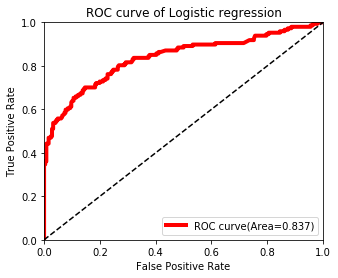

In [18]:
# AUC(Area Under the Curve)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print('AUC score : %.3f' % roc_auc)

# ROC curve 그래프
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label=f'ROC curve(Area={roc_auc:.3f})', 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc='lower right')
plt.show()

### Decision Tree(의사결정나무)
- 로지스틱 회귀모델과 더불어 분류 분석의 대표적인 모델
- 해석력이 좋다는 장점
- 스무고개

In [21]:
from sklearn.tree import DecisionTreeClassifier

# 학습, 모델 테스트, 예측값
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)
y_pred_probability = dtc.predict_proba(X_test)[:,1]

# 테스트 데이터셋에 대한 정확도, 정밀도 , 특이도 , f1 평가 지표
print(f'accuracy : {accuracy_score(y_test, y_pred):.2f}')
print(f'precision : {precision_score(y_test, y_pred):.2f}')
print(f'recall : {recall_score(y_test, y_pred):.2f}')
print(f'f1 : {f1_score(y_test, y_pred):.2f}')

accuracy : 0.75
precision : 0.68
recall : 0.63
f1 : 0.65


AUC score : 0.740


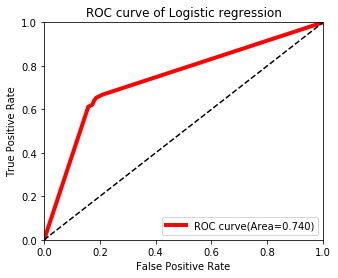

In [23]:
# AUC(Area Under the Curve)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print('AUC score : %.3f' % roc_auc)

# ROC curve 그래프
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label=f'ROC curve(Area={roc_auc:.3f})', 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc='lower right')
plt.show()

### 타이타닉 모델링
- Logistic Regression
- Support Vector Machine(SVM)
- k-Nearest Neighbor(kNN)
- Random Forest
- Naive Bayes

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.utils import shuffle

In [25]:
X_train, y_train = shuffle(train.loc[:, train.columns != 'survived'].values, train['survived'].values)
X_test, y_test = shuffle(test.loc[:, test.columns != 'survived'].values, test['survived'].values)

In [26]:
def train_and_test(model):
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    accuracy = round(model.score(X_train, y_train) * 100, 2)
    print('Accuracy : ', accuracy)
    return prediction

In [27]:
# Logistic Regression
log_pred = train_and_test(LogisticRegression())
# SVM
svm_pred = train_and_test(SVC())
# kNN
knn_pred_4 = train_and_test(KNeighborsClassifier(n_neighbors=4))
# Random Forest
rf_pred = train_and_test(RandomForestClassifier(n_estimators=100))
# Naive Bayes
nb_pred = train_and_test(GaussianNB())

Accuracy :  78.82
Accuracy :  87.45
Accuracy :  79.59
Accuracy :  97.6
Accuracy :  78.28


### 피처 엔지니어링
- http://blog.ggaman.com/1010
- 분류모델의 성능을 높이기 위함
- 피처 엔지니어링 : 모델에서 사용할 피처를 가공하는 분석 작업
- 수치형 : 결측값처리, 이상치 처리
- 범주형 : 원-핫 인코딩

In [28]:
# 데이터 다시 불러오기
train = pd.read_csv('../data/titanic_train.csv')
test = pd.read_csv('../data/titanic_test.csv')

# 불필요한 피처 제거
train = train.drop(['ticket', 'body', 'home.dest'], axis=1)
test = test.drop(['ticket', 'body', 'home.dest'], axis=1)

# 결측값 처리
replace_mean = train[train['age']>0]['age'].mean()
train['age'] = train['age'].fillna(replace_mean)
test['age'] = test['age'].fillna(replace_mean)

emberked_mode = train['embarked'].value_counts().index[0]
train['embarked'] = train['embarked'].fillna(emberked_mode)
test['embarked'] = test['embarked'].fillna(emberked_mode)

# 원-핫 인코딩
whole_df = train.append(test)
train_idx_num = len(train)

In [29]:
whole_df['cabin'].value_counts()[:10]

C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
D                  4
B96 B98            4
F33                4
F4                 4
C22 C26            4
C78                4
F2                 4
Name: cabin, dtype: int64

In [ ]:
train.info()

In [ ]:
train.tail(10)

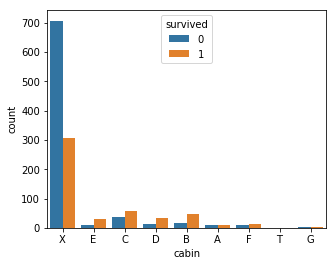

In [30]:
# 결측데이터는 'X'로 대체
whole_df['cabin'] = whole_df['cabin'].fillna('X')

# cabin 피처의 첫 번째 알파벳을 추출
whole_df['cabin'] = whole_df['cabin'].apply(lambda x:x[0])

ax = sns.countplot(x='cabin', hue='survived', data=whole_df)
plt.show()

In [31]:
# 추출한 'G'나 'T'를 'X' 대체

whole_df['cabin'] = whole_df['cabin'].replace({'G':'X', 'T':'X'})

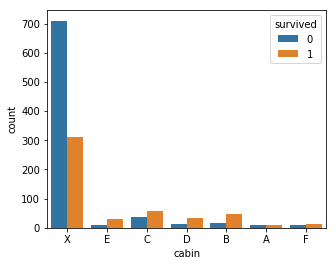

In [32]:
ax = sns.countplot(x='cabin', hue='survived', data=whole_df)
plt.show()

### name 피처

In [33]:
# 이름에서 호칭(이름 중간에 있는 것) 추출
name_grade = whole_df['name'].apply(lambda x : x.split(',', 1)[1].split('.')[0])
name_grade = name_grade.unique().tolist()
name_grade

[' Miss',
 ' Mr',
 ' Master',
 ' Mrs',
 ' Dr',
 ' Mlle',
 ' Col',
 ' Rev',
 ' Ms',
 ' Mme',
 ' Sir',
 ' the Countess',
 ' Dona',
 ' Jonkheer',
 ' Lady',
 ' Major',
 ' Don',
 ' Capt']

In [34]:
# 호칭에 따라 그루핑
grade_dict = {'A' : ['Rev', 'Col', 'Major', 'Dr', 'Capt', 'Sir'],
              'B' : ['Ms', 'Mme', 'Dona'],
              'C' : ['Jonkheer', 'the Countess'],
              'D' : ['Mr', 'Don'],
              'E' : ['Master'],
              'F' : ['Miss', 'Mlle', 'Lady']}

In [35]:
def give_grade(x):
    grade = x.split(', ', 1)[1].split('.')[0]
    
    for key, value in grade_dict.items():
        for title in value:
            if grade == title:
                return key
    return 'G'

whole_df['name'] = whole_df['name'].apply(lambda x : give_grade(x))

whole_df['name'].value_counts()

D    758
F    263
G    197
E     61
A     24
B      4
C      2
Name: name, dtype: int64

In [36]:
whole_df_encoded = pd.get_dummies(whole_df)
train = whole_df_encoded[:train_idx_num]
test = whole_df_encoded[train_idx_num:]

train.head()

,pclass,survived,age,sibsp,parch,fare,name_A,name_B,name_C,name_D,...,cabin_A,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_X,embarked_C,embarked_Q,embarked_S
0,2,1,13.000000,0,1,19.5000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,2,1,4.000000,1,1,23.0000,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,2,1,30.000000,1,0,13.8583,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,3,0,30.231444,0,0,7.7250,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
4,3,1,22.000000,0,0,7.7250,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


accuracy : 0.79
precision : 0.74
recall : 0.70
f1 : 0.72
AUC score : 0.853


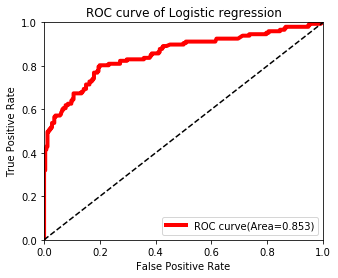

In [37]:
X_train, y_train = shuffle(train.loc[:, train.columns != 'survived'].values, train['survived'].values)
X_test, y_test = shuffle(test.loc[:, test.columns != 'survived'].values, test['survived'].values)

# 로지스틱 회귀 모델 학습
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)

# 학습 모델의 테스트 데이터셋에 대한 예측 결과 반환
y_pred = lr.predict(X_test) # 예측값
y_pred_probability = lr.predict_proba(X_test)[:,1] # 확률값

# 테스트 데이터셋에 대한 정확도, 정밀도 , 특이도 , f1 평가 지표
print(f'accuracy : {accuracy_score(y_test, y_pred):.2f}')
print(f'precision : {precision_score(y_test, y_pred):.2f}')
print(f'recall : {recall_score(y_test, y_pred):.2f}')
print(f'f1 : {f1_score(y_test, y_pred):.2f}')

# 로지스틱 회귀모델의 AUC 구하는 작업
# AUC(Area Under the Curve)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print('AUC score : %.3f' % roc_auc)

# ROC curve 그래프
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label=f'ROC curve(Area={roc_auc:.3f})', 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc='lower right')
plt.show()

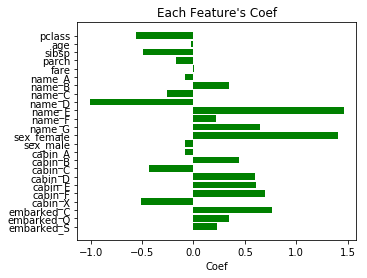

In [43]:
# 피처의 영향력을 파악 : 분류 모델의 피처 영향력을 시각화

## 예측 대상인 servived 피처를 제외한 다른 피처를 리스트로 반환
cols = train.columns.tolist()
cols.remove('survived')
y_pos = np.arange(len(cols))

# 각 피처들의 회귀분석계수를 그래프의 x축으로 하여 시각화
plt.rcParams['figure.figsize'] = [5, 4]
fig, ax = plt.subplots()
ax.barh(y_pos, lr.coef_[0], align='center', color='green', ecolor='blue')
ax.set_yticks(y_pos)
ax.set_yticklabels(cols)
ax.invert_yaxis()
ax.set_xlabel('Coef')
ax.set_title("Each Feature's Coef")

plt.show()

### K-Fold 교차검증(Cross Validation)
- 마지막 단계에서 완성된 분류 모델을 검증하는 단계
- 모델의 과적합 여부 검증(K-Fold 교차검증, 학습곡선)
- 가지고 있는 데이터세트를 훈련세트와 테스트세트로 번갈아 여러번 모델을 만들어 검증하는 것
- 훈련 세트와 테스트 세트를 나눌 때 , 두 데이터의 불균형을 낮추는 방법
- Stratified K-Fold : K-Fold의 단점을 보안한 검증방법

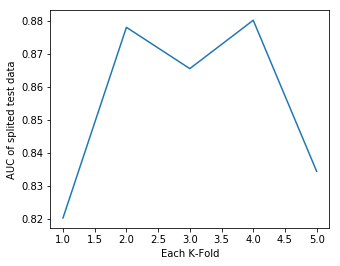

In [47]:
from sklearn.model_selection import KFold

k=5
# KFold 교차검증의 k값을 5로 설정(n_splits=5)
cv = KFold(k, shuffle=True, random_state=0)

auc_history=[]

# K-Fold를 5번 분할, 학습하는 작업 반복
for i, (train_data_row, test_data_row) in enumerate(cv.split(whole_df_encoded)):
    # 5개로 분할된 fold 중 4개는 학습데이터 1개는 테스트 데이터
    df_train = whole_df_encoded.iloc[train_data_row]
    df_test = whole_df_encoded.iloc[test_data_row]
    
    # 데이터를 학습데이터와 테스트 데이터로 분류
    X_train, y_train = df_train.loc[:, df_train.columns != 'survived'].values, df_train['survived'].values
    X_test, y_test = df_test.loc[:, df_test.columns != 'survived'].values, df_test['survived'].values

    # 로지스틱 회귀모델 학습
    lr = LogisticRegression(random_state=0)
    lr.fit(X_train, y_train)
    
    y_pred = lr.predict(X_test)
    y_pred_probability = lr.predict_proba(X_test)[:,1]
    
    # 테스트 데이터셋 AUC계산 후 auc_history에 저장
    # AUC(Area Under the Curve)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
    roc_auc = roc_auc_score(y_test, y_pred_probability)
    auc_history.append(roc_auc)
    
# auc_history에 저장된 다섯번의 학습결과(AUC)를 시각화
plt.xlabel('Each K-Fold')
plt.ylabel('AUC of splited test data')
plt.plot(range(1, k+1), auc_history)
plt.show()

- 데이터의 개수가 적어서 발생하는 문제
- 모든 실행에서 공통적으로 AUC 0.8 이상이면 과적합을 의심해볼 수 있다.

```bash
pip install scikit-plot
```

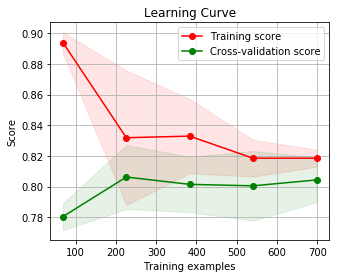

In [48]:
# 학습곡선
import scikitplot as skplt

skplt.estimators.plot_learning_curve(lr, X_train, y_train)
plt.show()

- 사이가 멀면 과적합일 수 있다
- 과적합 : 비슷한 데이터를 여러개 가지고 있는 것